
--------------------------------------------------------------------
DATA COMPUTED DIRECTLY FROM RAMS MASS AND NUMBER MIXING RATIOS
--------------------------------------------------------------------
Initial mass q (g/kg or g/m3) = 1.0000
Initial number n (#/kg or #/m3) = 1908.4
Initial Mean-mass-diameter (diam of the mean mass from q/n) (mm) = 1.0000

Characteristic diameter (mm) = 0.3467
Total number from gamma dist (#/unit) = 1908.4
Total mass from gamma dist (g/unit)   = 0.9992

--------------------------------------------------------------------
DIAMETERS COMPUTED FROM THE ** NUMBER ** SPECTRUM GAMMA DISTRIBUTION
--------------------------------------------------------------------
artithmetic_mean diam (mm)    = 0.6934
surface_area_mean diam (mm)   = 0.8492
volume_or_mass_mean diam (mm) = 1.0000

length_moment_mean diam (mm)       = 1.0400
surface_area_moment_mean diam (mm) = 1.3867
volume_moment_mean diam (mm)       = 1.7333
volume median diam (gamma) (mm)    = 1.6189
(1000,) (

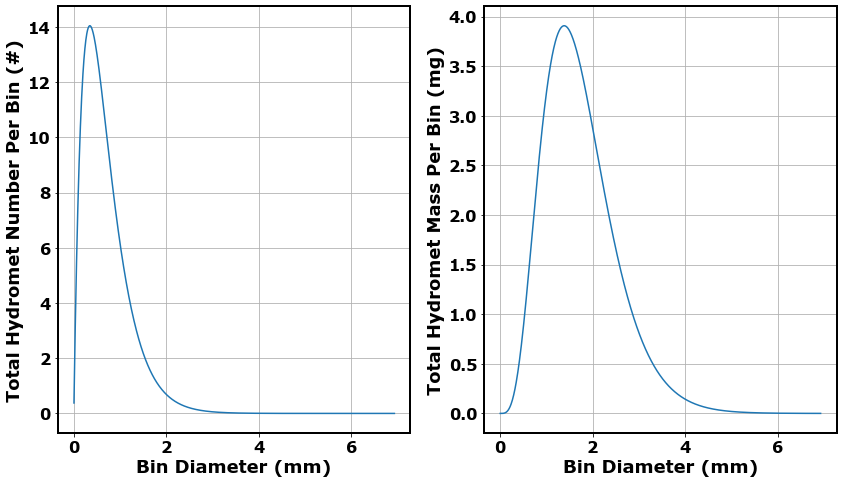

In [15]:
###################################################################################################
'''
This python code is used to compute various diameters of gamma distributions from input values
of RAMS hydrometeor type, hydrometeor mass mixing ratio, hydrometeor number mixing ratio, 
air density, and gamma distribution shape parameter (gnu). Note that RAMS gamma (gnu = mu + 1),
where gnu = 1 and mu = 0 is the Marshall-Palmer exponential size distribution.
The input portion for parameters is at the bottom of this code below the defs for "gammln" and
"calc_gamma_dist". Scroll to the end of the code to proceed.
'''
###################################################################################################
# Import numpy - the array library
import numpy as np
# Import matplotlib after tobac since tobac appears to limit inline plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Setting font parameters for title and axes
font = {'family' : 'verdana',
        'size'   : 16,
        'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2  #Set the value globally

# Set some fonts here for easy changing
font_axis      = 22
font_suptitle  = 18
font_xylabel   = 18
font_gridlabel = 11
font_colorbar  = 12
font_legend    = 12
font_title     = 18

###################################################################################################
# Numerical methods for ln(gamma) used by RAMS, taken from numerical recipes reference
def gammln(gnu):
    
    # Compute gammaln section for a given gnu
    cof= [76.18009173, -86.50532033, 24.01409822,-1.231739516, .120858003e-2, -.536382e-5]
    stp = 2.50662827465
    one = 1.0
    x=gnu-1
    tmp=x+5.5
    tmp=(x+0.5)*np.log(tmp)-tmp
    ser=1
    for j in range(5):
        x=x+one
        ser=ser+cof[j]/x
    gammln = tmp+np.log(stp*ser)
    
    return gammln

###################################################################################################
def calc_gamma_dist(lcat,gnu,qr,nr,dn0,method):

    # Set a few static items
    nbins = 1000

    # Mean mass diameter (meters), calcuated from m = alpha * (D^beta)
    # Coefficients for computing spherical cloud/rain/drizzle drop using mass/diameter
    # relationship given as:  m = alpha * (D ^ beta) 
    if lcat == 1 or lcat == 2 or lcat == 8:
        ccfmas = 524. # alpha
        ppwmas = 3.   # beta

    # Convert mass mixing ratio (kg/kg) and number mixing ratio (#/kg) into
    # volume units of kg/m3 and #/m3 by multiplying by air density (dn0; kg/m3)
    qr = qr * dn0 # kg/m3
    nr = nr * dn0 # Number/m3

    print()
    print('--------------------------------------------------------------------')
    print('DATA COMPUTED DIRECTLY FROM RAMS MASS AND NUMBER MIXING RATIOS')
    print('--------------------------------------------------------------------')
    
    print(f'Initial mass q (g/kg or g/m3) = {qr * 1000.:.4f}')
    print(f'Initial number n (#/kg or #/m3) = {nr:.1f}')

    # Mean mass diameter 'mmd' (diameter of the mean mass) (meters)
    # Compute from mass-concentration (qr) and number concentration (nr)
    mmd = (qr / (nr * ccfmas))**(1./ppwmas)
    print(f'Initial Mean-mass-diameter (diam of the mean mass from q/n) (mm) = {mmd*1000.:.4f}')
    print()
    
    # Compute characteristic diameter 'dn' (meters)
    dmbodn=( np.exp( gammln(gnu+ppwmas)-gammln(gnu) ) )**(1./ppwmas)
    dn = mmd / dmbodn
    print(f'Characteristic diameter (mm) = {dn*1000.:.4f}')
    
    # Compute distribution bin increment (meters)
    # Scaling this relative to 'dn'. It does not have to be scaled by 0.02, but depends
    # on the needed diamter range scale and the number of bins 'nbins'
    dD = 0.02 * dn
    # Set distribution bin sizes and gamma to zero for initialization
    db = np.zeros(nbins)
    fmg = np.zeros(nbins)
    # Set array of bin-centers
    dsizes = np.arange(1,nbins+1)-0.5
    # Set the bin size array (meters)
    db = dD*dsizes
    # General gamma distribution (fraction per bin) whose sum will equal 1.
    fmg = dD*(db/dn)**(gnu-1.)/(dn*np.exp(gammln(gnu)))*np.exp(-db/dn)

    # Compute Gamma Number distribution from total number contentration
    Nd = nr * fmg # units of number in each bin
    # Compute Gamma Mass distribution from number distribution (Nd)
    Md = Nd * (524.*db**3.0) # units of (kg) in each bin
    
    # Sum up the number concentration values from the gamma distribution just as a
    # check to see that the total number was distributed correctly
    total_number_from_gamma = np.sum(Nd)
    print(f'Total number from gamma dist (#/unit) = {total_number_from_gamma:.1f}')

    # Compute total mixing ratio from number distribution but convert components to
    # metric units first for consistency. (db is in millimeters from above)
    # q = (pi / 6) * rho_water * sum [N(D) D^3 dD]
    mixing_ratio_from_number_gamma = np.sum(Nd * db**3.) \
                                    * 3.14159 / 6. * 1000.
    # Now convert kg/kg to g/kg for convenience
    mixing_ratio_from_number_gamma = mixing_ratio_from_number_gamma * 1000.
    print(f'Total mass from gamma dist (g/unit)   = {mixing_ratio_from_number_gamma:.4f}')

    ###############################################################################################
    print()
    print('--------------------------------------------------------------------')
    print('DIAMETERS COMPUTED FROM THE ** NUMBER ** SPECTRUM GAMMA DISTRIBUTION')
    print('--------------------------------------------------------------------')

    # Compute the arithmetic-mean or average-diameter for mean-(drop)-diameter or
    # the count-mean-diameter.
    # Arithmetic mean diameter, D[1,0] : the average of the diameters of all the particles
    # in the sample.
    arithmetic_mean = 1000. * np.sum(Nd * db) / nr
    print(f'artithmetic_mean diam (mm)    = {arithmetic_mean:.4f}')

    # Compute the surface area mean diameter or diameter of mean surface area.
    # Surface area mean diameter, D[2,0]
    # The diameter of a particle whose surface area, if multiplied by the total number 
    # of particles, will equal the total surface area of the sample.
    surface_area_mean = 1000. * ( np.sum(Nd * db**2) / nr ) ** (1./2.)
    print(f'surface_area_mean diam (mm)   = {surface_area_mean:.4f}')

    # Compute volume mean diameter. Basically same as mass mean diameter or diameter
    # of the mean mass (volume).
    # Volume mean diameter, volume-number mean diameter, D[3,0]
    # The diameter of a particle whose volume, if multiplied by the total number of 
    # particles, will equate the total volume of the sample.
    volume_mean = 1000. * ( np.sum(Nd * db**3.) / nr ) ** (1./3.)
    print(f'volume_or_mass_mean diam (mm) = {volume_mean:.4f}')

    print()

    # Compute length_moment_mean.
    # May also be called surface-length or length-weighted mean.
    length_moment_mean = 1000. * np.sum(Nd * db**2) / np.sum(Nd * db)
    print(f'length_moment_mean diam (mm)       = {length_moment_mean:.4f}') 

    # Compute surface_area_moment_mean.
    # May also be called volume-surface or surface-weighted mean diameter, or 
    # surface-mean-diameter. D[3,2]
    surface_area_moment_mean = 1000. * np.sum(Nd * db**3) / np.sum(Nd * db**2)
    print(f'surface_area_moment_mean diam (mm) = {surface_area_moment_mean:.4f}')     

    # Compute volume_moment_mean diameter.
    # May also be called weight-moment-mean-diameter or volume-weighted-mean-diameter
    # or mass-weighted-mean-diameter or mass-mean-diameter
    # Volume (or mass) moment mean diameter, D[4,3]. This value is a superior indicator than 
    # other means of which particle sizes contain the majority of the volume.
    volume_moment_mean = 1000. * np.sum(Nd * db**4) / np.sum(Nd * db**3)
    print(f'volume_moment_mean diam (mm)       = {volume_moment_mean:.4f}')
    # Compute median volume diameter (meters) from volume_moment_mean above
    # Use (gnu-1) since RAMS gnu is different than Williams et al.
    D0_d43 = volume_moment_mean * (3.67 + (gnu-1.)) / (4.0 + (gnu-1.))
    print(f'volume median diam (gamma) (mm)    = {D0_d43:.4f}')
    
    gamsum1=0
    gamsum2=0
    print(Nd.shape,db.shape)
    for n in range(nbins):
        gamsum2 = gamsum2 + Md[n]
        if db[n] < volume_moment_mean/1000.:
            gamsum1 = gamsum1 +  Md[n]
    print('gamsum1',gamsum1,gamsum2,gamsum1/gamsum2)
    

    ###############################################################################################
    print()
    print('--------------------------------------------------------------------')
    print('DIAMETERS COMPUTED FROM THE ** MASS ** SPECTRUM GAMMA DISTRIBUTION')
    print('--------------------------------------------------------------------')

    # Compute "arithmetic" mean diameter of the mass distribution.
    # Also called mass spectrum mean diameter. Can also be computed below as
    # the volume-moment mean diameter or mass-weighted-mean-diameter or mass-mean-diameter.
    mass_spectrum_mean = 1000. * np.sum(Md * db) / qr
    print(f'mass_spectrum_mean diam (mm)  = {mass_spectrum_mean:.4f}')

    print()
    
    # Standard deviation of mass spectrum (mm)
    Dm=volume_moment_mean/1000. # (meters)
    Sigma_m = np.sqrt( np.sum(((db-Dm)**2)*Md) / np.sum(Md))
    print(f'sigma-mass-spectrum (mm)   = {Sigma_m*1000.:4f}')
    
    # Standard deviation of number spectrum (mm)    
    Dm=volume_mean/1000.
    Sigma_m = np.sqrt( np.sum(((db-Dm)**2)*Nd) / np.sum(Nd))
    print(f'sigma-number-spectrum (mm) = {Sigma_m*1000.:4f}')
    
    print()
    
    # Plot distribution
    fig,ax = plt.subplots(1,2,figsize=(12,7))
    pltbins=nbins
    ax[0].plot(db[0:pltbins]*1000., Nd[0:pltbins])
    ax[0].set_ylabel('Total Hydromet Number Per Bin (#)',fontsize=font_xylabel,fontweight='bold')
    ax[0].set_xlabel('Bin Diameter (mm)',fontsize=font_xylabel, fontweight='bold')
    ax[0].grid()
    ax[1].plot(db[0:pltbins]*1000., Md[0:pltbins] * 1.e6)
    ax[1].set_ylabel('Total Hydromet Mass Per Bin (mg)',fontsize=font_xylabel,fontweight='bold')
    ax[1].set_xlabel('Bin Diameter (mm)',fontsize=font_xylabel, fontweight='bold')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

    return

###################################################################################################
###################################################################################################
###################################################################################################
# Input your hydromteor mass mixing ratio (mixr) and number mixing ratio (numr) below along 
# with the air density (airdens). Air density is used to convert from mixing ratio units 
# (/kg of air) to volume units (/m3)
###################################################################################################
###################################################################################################
###################################################################################################

# This example is set up for RAIN with diameter of the mean mass (q/n) of 1.0000 mm

# RAMS hydrometeor category (1=cloud, 2=rain, 8=drizzle; note these liquid categories use 
# the same sphereical assumption). (3=cloud-ice, 4=snow, 5=aggregates, 6=graupel, 7=hail).
lcat = 2 # Values of 1 thru 8 as noted above (only 1,2,8 work for now)
mixr = .001 # kg/kg
numr = 1908.39694 # number-of-hydrometeors/kg
airdens = 1.0 # kg/m3
gnu = 2 # shape of the gamma distribution (gnu=1 is Marshall-Palmer exponential)

# Call the gamma distribution function to output lots of distribution diameter information
calc_gamma_dist(lcat,gnu,mixr,numr,airdens,2)

###################################################################################################